In [10]:
from os import listdir
from pandas import read_excel
import numpy as np # Numpy removed support for np.complex np.__version__ == 1.22.0 was used for this notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from itertools import cycle
from progressbar import ProgressBar


In [4]:
theta_axis = []
freqeuncy_axis = []
data_axis = []


filedir = 'Data 5V Driving'


for file in listdir(filedir):
    if file[-5:] == ".xlsx":
        theta = file.split('-nodes-')[0]
        frequency = file.split('-nodes-')[1][:-5]
        while len(frequency) < 5:
            frequency = frequency + '0'
        theta_axis.append(theta)
        freqeuncy_axis.append(frequency)
        data_axis.append(read_excel(f'{filedir}/{file}', index_col = None))
    
    

In [12]:
def fit_data(reservoir_states, target, order):
    sync = order - 1
    alphas = np.arange(0.000000001, 0.5, 0.1)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    output_network = RidgeCV(alphas = alphas, cv = cv)
    
    # scale and save the training data
    trained_data = reservoir_states[sync:len(target)+sync, :]
    # Train the output network.
    output_network = output_network.fit(trained_data, target)
    
    return output_network.score(trained_data, target), output_network

def parity_success_rate(output, target):
    binary_output = []
    halfway = (max(target) - min(target)) / 2
    for symbol in output:
        if symbol > halfway:
            binary_output.append(1)
        else:
            binary_output.append(0)
    success = 0
    for i in range(len(target)):
        if binary_output[i] == target[i]:
            success += 1

    return success / len(target)

def mutual_information_parity(sr):
    if sr == 1.0:
        return sr*np.log2(2*sr)
    else:
        return sr*np.log2(2*sr) + (1-sr)*np.log2(2*(1-sr))
    
def calculate_parity_stream(bit_stream, order, delta):
    parity_stream = np.array([])
    for i in range(delta):
        parity_stream = np.append(parity_stream, 0)
    for i in range(order + delta - 1, len(bit_stream)):
        parity_sum = 0
        for ii in range(order):
            parity_sum += float(bit_stream[i - delta - ii])
        parity = parity_sum % 2
        parity_stream = np.append(parity_stream, parity)
        
    return parity_stream


In [ ]:
order = [1, 2, 3, 4, 5, 6, 7]
delta = np.arange(10,-1,-1)

#r2_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
#p_axis =  {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
#mc_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
#mi_axis = {1:[],2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
train_until = 1000


for test in order:
    bar = ProgressBar(len(data_axis))
    i=0
    print(f"Order {test}")
    bar.start()
    for dat in data_axis:
        bar.update(i)
        MI = []
        #calculating the mutual information/memory capcaity
        for d in delta:
            parity_stream = calculate_parity_stream(dat["inputs"], test, d)
            arry = dat.to_numpy()[:,1:-1]
            r2, net = fit_data(arry, parity_stream[:train_until], test)
            end= len(parity_stream)
            sr = parity_success_rate(net.predict(arry[train_until - end:,:]), parity_stream[train_until - end:])
            mi = mutual_information_parity(sr)
            MI.append(mi)
        i+=1
        mi_axis[test].append(MI)
        mc_axis[test].append(np.sum(MI))
        p_axis[test].append(sr)
        r2_axis[test].append(r2)
    bar.finish()
        
        

Order 4


100% |#########################################################################|


Order 5


# Parity Success Rate plotting


/var/folders/4y/pym7xd1d7nl5hf_zztc0f1jh0000gn/T/ipykernel_21970/3074095337.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


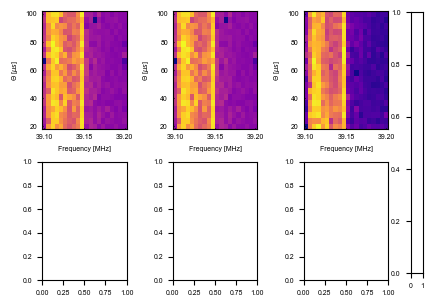

In [26]:
# frequency processing
frequency = []
for f in freqeuncy_axis:
    frequency.append(float(f)*1e3) # Hz
frequency = np.array(frequency)

# Theta processing
theta = []
for t in theta_axis:
    theta.append(float(t)) # seconds
theta = np.array(theta)


# Sort by frequency first
frequency_inds = frequency.argsort()
frequency_sorted = frequency[frequency_inds]
theta_sorted = theta[frequency_inds]

order1 = np.array(mc_axis[1])[frequency_inds]
order2 = np.array(mc_axis[2])[frequency_inds]
order3 = np.array(mc_axis[3])[frequency_inds]
order4 = np.array(p_axis[4])[frequency_inds]
order5 = np.array(p_axis[5])[frequency_inds]
order6 = np.array(p_axis[6])[frequency_inds]



# Reshape it to be a 2D array (11 frequencies invesigated)
frequency_sorted = frequency_sorted.reshape(20, 20)
theta_sorted = theta_sorted.reshape(20, 20)
order1 = order2.reshape(20,20)
order2 = order2.reshape(20,20)
order3 = order3.reshape(20,20)
order4 = order4.reshape(20,20)
order5 = order5.reshape(20,20)
order6 = order6.reshape(20,20)

# Then sort by theta shape (20 theta)
theta_inds = theta_sorted.argsort()
for i in range(20):
    theta_sorted[i] = theta_sorted[i][theta_inds[i]]
    frequency_sorted[i] = frequency_sorted[i][theta_inds[i]]
    order1[i] = order2[i][theta_inds[i]]
    order2[i] = order2[i][theta_inds[i]]
    order3[i] = order3[i][theta_inds[i]]
    order4[i] = order4[i][theta_inds[i]]
    order5[i] = order5[i][theta_inds[i]]
    order6[i] = order6[i][theta_inds[i]]


f_labels = frequency_sorted[:, 0]/1e9
th_labels = theta_sorted[0, :]*1e6

mpl.rcParams.update({'font.size': 5})
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"


c = 'plasma'
fig, ax = plt.subplots(2,3, figsize=(4,3))

ax[0,0].tick_params(direction='in',length=1)
im = ax[0, 0].pcolormesh(f_labels, th_labels, order1.transpose(), cmap = c, shading='nearest')
ax[0, 0].set_xlabel('Frequency [MHz]')
ax[0, 0].set_ylabel('$\Theta$ [$\mu s$]')

ax[0,1].tick_params(direction='in',length=1)
ax[0, 1].pcolormesh(f_labels, th_labels, order2.transpose(), cmap = c, shading='nearest')
ax[0, 1].set_xlabel('Frequency [MHz]')
ax[0, 1].set_ylabel('$\Theta$ [$\mu s$]')

ax[0, 2].pcolormesh(f_labels, th_labels, order3.transpose(), cmap = c, shading='nearest')
ax[0, 2].set_xlabel('Frequency [MHz]')
ax[0, 2].set_ylabel('$\Theta$ [$\mu s$]')
ax[0, 2].tick_params(direction='in',length=1)

ax[1, 0].pcolormesh(f_labels, th_labels, order4.transpose(), cmap = c, shading='nearest')
ax[1, 0].set_xlabel('Frequency [MHz]')
ax[1, 0].set_ylabel('$\Theta$ [$\mu s$]')
ax[1, 0].tick_params(direction='in',length=1)


ax[1, 1].pcolormesh(f_labels, th_labels, order5.transpose(), cmap = c, shading='nearest')
ax[1, 1].set_xlabel('Frequency [MHz]')
ax[1, 1].set_ylabel('$\Theta$ [$\mu s$]')
ax[1, 1].tick_params(direction='in',length=1)


ax[1, 2].pcolormesh(f_labels, th_labels, order6.transpose(), cmap = c, shading='nearest')
ax[1, 2].set_xlabel('Frequency [MHz]')
ax[1, 2].set_ylabel('$\Theta$ [$\mu s$]')
ax[1, 2].tick_params(direction='in',length=1)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.1, 0.03, 0.87])
#fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.savefig(f'{filedir}_parity_task_sucess.png', dpi=500, bbox_inches="tight")

# Memory Capacity Plotting


<ipython-input-61-357e93dd65bc>:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


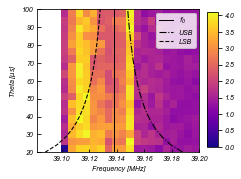

In [61]:
f_0 = 39.138

f_1w_p = f_0 + 1/th_labels
f_1w_m = f_0 - 1/th_labels


# frequency processing
frequency = []
for f in freqeuncy_axis:
    frequency.append(float(f)) # Hz
frequency = np.array(frequency) 

# Theta processing
theta = []
for t in theta_axis:
    theta.append(float(t)) # seconds
theta = np.array(theta)

# Sort by frequency first
frequency_inds = frequency.argsort()
frequency_sorted = frequency[frequency_inds]
theta_sorted = theta[frequency_inds]

order2 = np.array(mc_axis[2])[frequency_inds]



# Reshape it to be a 2D array (11 frequencies invesigated)
frequency_sorted = frequency_sorted.reshape(20,20)
theta_sorted = theta_sorted.reshape(20,20)
order2 = order2.reshape(20,20)



# Then sort by theta shape (7 theta)
theta_inds = theta_sorted.argsort()
for i in range(9):
    theta_sorted[i] = theta_sorted[i][theta_inds[i]]
    frequency_sorted[i] = frequency_sorted[i][theta_inds[i]]
    order2[i] = order2[i][theta_inds[i]]



f_labels = frequency_sorted[:, 0]/1e6
th_labels = theta_sorted[0, :]*1e6

mpl.rcParams.update({'font.size': 7})
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.style'] = "italic"

c = 'plasma'
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))
ax.tick_params(direction='in')

ax.axvline(f_0, color = 'k', linestyle = '-', linewidth = 1, label = '$f_0$')
ax.plot(f_1w_p, th_labels, 'k-.', linewidth = 1.1, label = 'USB')
ax.plot(f_1w_m, th_labels, 'k--', linewidth = 1.1, label = 'LSB')
plt.legend()


ma = np.max(order2)
im = ax.pcolormesh(f_labels, th_labels, order2.transpose(),vmin=0, vmax=ma, cmap = c, shading='nearest')
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Theta [$\mu s$]')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.96, 0.18, 0.05, 0.75])
fig.colorbar(im, cax=cbar_ax)

# Plot center frequency and AM sidebands

#ax.set_xlim((39.1, 39.2))
plt.tight_layout()
plt.savefig(f'{filedir}_memory_capacity.png', dpi=500, bbox_inches="tight")

In [43]:
best_perform = np.argmax(order2)

print(frequency_sorted[best_perform//20, best_perform%20])
print(theta_sorted[best_perform//20, best_perform%20])


39115789.0
4.947368421052632e-05


AttributeError: 'numpy.ndarray' object has no attribute 'tick_params'

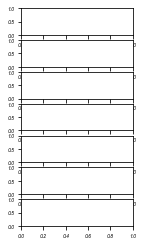

In [44]:
mpl.rcParams.update({'font.size': 5})
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.style'] = "italic"

# The highest performing parameters
final_network = read_excel(f'{filedir}/3.68421052631579e-05-nodes-39110526.xlsx')
arry = final_network.to_numpy()[:,1:-1]

fig, ax = plt.subplots(7,1,figsize = (2, 4))
ax.tick_params(direction='in')

ax[0].step(np.linspace(0,49,50), final_network["inputs"][-50:], 'k', linewidth=0.5)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].set_ylim((-0.1, 1.1))
ax[0].tick_params(direction='in', length=1)

train_until = 1000

for order in range(2,8):
    parity_stream = calculate_parity_stream(final_network["inputs"], order, 0)
    r2, net = fit_data(arry, parity_stream[:train_until], order)
    end= len(parity_stream)
    sr = parity_success_rate(net.predict(arry[train_until - end:,:]), parity_stream[train_until - end:])
    print(sr)
    ax[order-1].step(np.linspace(0,49,50), parity_stream[-50:], 'k', linewidth=0.5)
    ax[order-1].step(np.linspace(0,49,50), net.predict(arry[-50:,:]),'g-', linewidth=0.5)
    #ax[order-1].tick_params(direction='in', length=1)
    ax[order-1].set_xticks([])
    ax[order-1].set_ylim((-0.1, 1.1))
    ax[order-1].set_yticks([0,1])

plt.legend(["Target", "Prediction"],loc=(0.63, 7.45))
plt.tight_layout()
plt.savefig(f'{filedir}_parity_task.png', dpi=500)

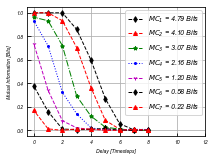

In [45]:
fig, ax = plt.subplots(1,1,figsize = (3,2.25))
max_ind = np.argmax(mc_axis[2])

mpl.rcParams.update({'font.size': 7})
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"


lines = ["kd--","r^--","g*-.","b.:", "m1--"]
linecycler = cycle(lines)

for key in mi_axis:
    ax.plot(np.arange(8,-1,-1),mi_axis[key][max_ind], next(linecycler), markersize = 4, label=f"$MC_{key}$ = {np.sum(mi_axis[key][max_ind]):.2f} Bits", linewidth=1)
    
plt.grid('both')
ax.tick_params(direction="in")
plt.xlabel('Delay [Timesteps]')
plt.ylabel('Mutual Information [Bits]')
plt.xlim((-0.5, 12))
plt.legend()
plt.tight_layout()

plt.savefig('mutual_information.png',layout='tight', dpi=500)